In [1]:
# Real life data

import logging
import threading
import itertools
import json
import os
import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import axes3d
import seaborn as seabornInstance
from sqlalchemy import Column, Integer, String, Float, DateTime, Boolean, func

from iotfunctions import base
from iotfunctions import bif
from iotfunctions import entity
from iotfunctions import metadata
from iotfunctions.metadata import EntityType
from iotfunctions.db import Database
from iotfunctions.enginelog import EngineLogging
from iotfunctions import estimator
from iotfunctions.ui import (UISingle, UIMultiItem, UIFunctionOutSingle,
                 UISingleItem, UIFunctionOutMulti, UIMulti, UIExpression,
                 UIText, UIStatusFlag, UIParameters)
from mmfunctions.anomaly import (SaliencybasedGeneralizedAnomalyScore, SpectralAnomalyScore,
                 FFTbasedGeneralizedAnomalyScore, KMeansAnomalyScore)
import datetime as dt
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, roc_auc_score, r2_score

import scipy as sp
import scipy.fftpack
import skimage as ski

from skimage import util as skiutil # for nifty windowing
import pyod as pyod
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from pyod.models.knn import KNN
from pyod.models.iforest import IForest
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

EngineLogging.configure_console_logging(logging.INFO)

#### Train a 2-layered LSTM in Watson Machine Learning

 
Telemanom ([Detecting Spacecraft Anomalies Using LSTMs and Nonparametric Dynamic Thresholding](https://arxiv.org/pdf/1802.04431.pdf) - 2018


Let's find out first what ML libraries are supported by WML.


### Basic Definitions

Forecast 24 data points from a sequence length of 200

In [2]:

n_predictions = 24
n_sequence_length = 200

logger = logging

### Load data

In [3]:
# load data
df_input = pd.read_csv('BP_DATA/IoTData.csv', parse_dates=['DATETIME'], comment='#')
df_input.rename(columns={'DATETIME': 'timestamp'}, inplace=True)
#df_input = df_input.asfreq('H')
df_input.set_index('timestamp', inplace=True)

### Build features

In [4]:
# build features

def addDailyTimeFeatures(df):
    df['hour'] = df.index.hour / 10
    #df['day'] = df.index.dayofyear
    #df['week'] = df.index.weekofyear
    return df

def addConsumptionLagDay(df):
    dfkw = df[['KW']]
    dfkw2 = df.merge(dfkw.assign(date = df.index+pd.Timedelta(days=1)), left_on=['timestamp'],
                       right_on=['date'], how='left', suffixes=['','_1dayago']).\
                 dropna().rename(columns={'date':'timestamp'}).set_index('timestamp')
    return dfkw2

def addConsumptionLag2Days(df):
    dfkw = df[['KW']]
    dfkw2 = df.merge(dfkw.assign(date = df.index+pd.Timedelta(days=2)), left_on=['timestamp'],
                       right_on=['date'], how='left', suffixes=['','_2daysago']).\
                 dropna().rename(columns={'date':'timestamp'}).set_index('timestamp')
    return dfkw2

def addConsumptionLagHour(df):
    dfkw = df[['KW']]
    dfkw2 = df.merge(dfkw.assign(date = df.index+pd.Timedelta(hours=1)), left_on=['timestamp'],
                       right_on=['date'], how='left', suffixes=['','_1hourago']).\
                 dropna().rename(columns={'date':'timestamp'}).set_index('timestamp')
    return dfkw2

def addConsumptionLag2Hours(df):
    dfkw = df[['KW']]
    dfkw2 = df.merge(dfkw.assign(date = df.index+pd.Timedelta(hours=2)), left_on=['timestamp'],
                       right_on=['date'], how='left', suffixes=['','_2hoursago']).\
                 dropna().rename(columns={'date':'timestamp'}).set_index('timestamp')
    return dfkw2

def fixBlueMonday(df):
    df_blue_monday = df[(df.index.weekday != 0) | (df.index.hour != 9)].\
                        resample('1H').interpolate()
    return df_blue_monday


#featureList = ['KW','TEMP_AIR','UMIDADE_REL']
featureList = ['KW','TEMP_AIR']
stdscal = StandardScaler()
np_input2 = stdscal.fit_transform(df_input[featureList])

df_input2 = pd.DataFrame(np_input2, columns=featureList, index=df_input.index)

df_input2 = fixBlueMonday(df_input2)
df_input2 = addConsumptionLagDay(df_input2)
df_input2 = addConsumptionLag2Days(df_input2)
df_input2 = addConsumptionLagHour(df_input2)
df_input2 = addConsumptionLag2Hours(df_input2)


df_input2 = addDailyTimeFeatures(df_input2)


In [5]:
df_input2.head(4)

,KW,TEMP_AIR,KW_1dayago,KW_2daysago,KW_1hourago,KW_2hoursago,hour
timestamp,,,,,,,
2019-09-18 03:00:00,0.797056,0.498175,0.742610,0.041041,0.797056,0.807945,0.3
2019-09-18 04:00:00,0.807945,0.498175,0.633719,-0.189186,0.797056,0.797056,0.4
2019-09-18 05:00:00,0.709943,0.658531,0.611941,-0.419412,0.807945,0.797056,0.5
2019-09-18 06:00:00,0.775277,0.681439,0.699054,-0.649639,0.709943,0.807945,0.6


### Build Training and Test data

In [6]:
def shape_data(arr, shuffle=False):
    data = []
    for i in range(len(arr) - n_sequence_length - n_predictions):
        data.append(arr[i:i + n_sequence_length + n_predictions])
        
    data = np.array(data)
    # leave that to Keras model.fit
    #if shuffle:
    #    np.random.shuffle(data)
    X = data[:, :-n_predictions, :]
    y = data[:, -n_predictions:, 0]      
    return X,y


X_train,y_train = shape_data(df_input2[0:7000].values, shuffle=True)
X_test, y_test = shape_data(df_input2[7000:].values, shuffle=False)

In [7]:
(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

((6776, 200, 7), (6776, 24), (1146, 200, 7), (1146, 24))

### Instantiate model

Using TensorFlow backend.


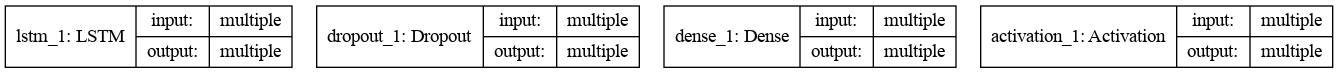

In [8]:
from keras.models import Sequential, load_model
from keras.callbacks import History, EarlyStopping
from keras.layers.recurrent import LSTM
from keras.layers.core import Dense, Activation, Dropout
from keras.metrics import MeanSquaredError,MeanAbsoluteError
from keras.utils.vis_utils import plot_model


n_features = X_train.shape[2]


model_metric = MeanSquaredError()

model = Sequential()

''''
model.add(LSTM(units=50, 
               input_shape=(None, n_features),
               return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, 
               input_shape=(None, n_features),
               return_sequences=True))
model.add(Dropout(0.2))
'''

model.add(LSTM(50, 
               return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(n_predictions))
model.add(Activation('linear'))

model.compile(loss='mse', optimizer='adam', metrics=[model_metric])


plot_model(model, show_shapes=True, show_layer_names=True)

In [18]:
cbs = [History(), EarlyStopping(monitor='val_loss', patience=3, min_delta=0.003, verbose=1)]
history = model.fit(X_train, y_train, batch_size=64, epochs=27, validation_split=0.2, 
                    shuffle=True, callbacks=cbs, verbose=True)


Train on 5420 samples, validate on 1356 samples
Epoch 1/27
5420/5420 [==============================] - 22s 4ms/step - loss: 0.7466 - mean_squared_error: 0.7466 - val_loss: 0.5954 - val_mean_squared_error: 0.5954
Epoch 2/27
5420/5420 [==============================] - 20s 4ms/step - loss: 0.4558 - mean_squared_error: 0.4558 - val_loss: 0.4855 - val_mean_squared_error: 0.4855
Epoch 3/27
5420/5420 [==============================] - 22s 4ms/step - loss: 0.4048 - mean_squared_error: 0.4048 - val_loss: 0.4355 - val_mean_squared_error: 0.4355
Epoch 4/27
5420/5420 [==============================] - 22s 4ms/step - loss: 0.3821 - mean_squared_error: 0.3821 - val_loss: 0.4138 - val_mean_squared_error: 0.4138
Epoch 5/27
5420/5420 [==============================] - 19s 3ms/step - loss: 0.3593 - mean_squared_error: 0.3593 - val_loss: 0.2891 - val_mean_squared_error: 0.2891
Epoch 6/27
5420/5420 [==============================] - 19s 3ms/step - loss: 0.3409 - mean_squared_error: 0.3409 - val_loss: 0.

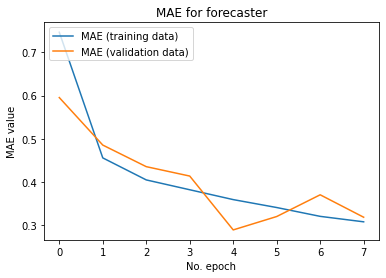

In [20]:
# Plot history: MAE
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.title('MAE for forecaster')
plt.ylabel('MAE value')
plt.xlabel('No. epoch')
plt.legend(loc="upper left")
plt.show()

In [21]:
model.evaluate(X_test, y_test)

1146/1146 [==============================] - 1s 1ms/step


[0.4285106124782229, 0.4285106360912323]

In [22]:
#model.evaluate(X_train, y_train)
X_train.shape

(6776, 200, 7)

In [23]:
X_train[-24:0].shape

(0, 200, 7)

In [24]:
act = y_train[-2:-1].reshape(-1,1)
pred = model.predict(X_train[-2:-1]).reshape(-1,1)

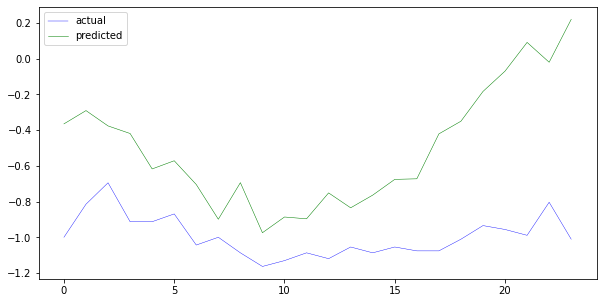

In [25]:
#arr = np.ones(chan.y_test.size)
fig, ax = plt.subplots(1, 1, figsize=(10, 5), squeeze=False)
ax[0,0].plot(act, lw=0.4, color='blue', label='actual')
ax[0,0].plot(pred, lw=0.5, color='green', label='predicted')
#ax[1,0].plot(chan.y_hat[6700:], lw=1, color='brown', label='predicted')
ax[0,0].legend()


In [9]:
import torch
import torch.autograd
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.utils.data.dataset import random_split


def initialize_weights(model):
    print('initialize weights')
    if type(model) in [nn.Linear]:
        nn.init.xavier_uniform_(model.weight.data)
    elif type(model) in [nn.LSTM, nn.RNN, nn.GRU]:
        nn.init.xavier_uniform_(model.weight_hh_l0)
        nn.init.xavier_uniform_(model.weight_ih_l0)

def repackage_hidden(h):
    """Wraps hidden states in new Tensors, to detach them from their history."""
    if isinstance(h, torch.Tensor):
        return h.detach()
    else:
        return tuple(repackage_hidden(v) for v in h)

class LSTM_2L(nn.Module):
    def __init__(self, n_features = 1, hidden_dims = [80,80], seq_length = 250,
                 batch_size = 64, n_predictions = 10, dropout = 0.1):
        super(LSTM_2L, self).__init__()
        print ('LSTM_2L', n_features, hidden_dims, seq_length, batch_size, n_predictions, dropout)

        self.n_features = n_features
        self.hidden_dim = hidden_dims[0]  # ignore second component for pytorch
        self.seq_length = seq_length
        self.num_layers = len(hidden_dims)
        self.batch_size = batch_size

        # using nn.LSTM so both layers end up with the same number of hidden dimensions
        self.lstm1 = nn.LSTM(
            input_size = self.n_features,
            hidden_size = self.hidden_dim,
            batch_first = True,
            dropout = dropout,
            num_layers = 2)

        self.linear = nn.Linear(self.hidden_dim, n_predictions)
        self.hidden = self.init_hidden_state()

    def init_hidden_state(self):
        #initialize hidden states (h_0, c_0)
        logger.debug('Hidden dimensions are: ' + str(self.num_layers) + ', ' +
                     str(self.batch_size) + ', ' + str(self.hidden_dim))

        return (
            Variable(torch.randn(self.num_layers, self.batch_size, self.hidden_dim)), #.to(self.device),
            Variable(torch.randn(self.num_layers, self.batch_size, self.hidden_dim)) #.to(self.device),
            )

    def forward(self, sequences, hidden = None):

        try:
            batch_size, seq_len, n_features = sequences.size()  # batch first
            logger.debug ('forward| Batch size: ' + str(batch_size) + ' Sequence length: ' + 
                          str(seq_len) + 'Output length:' + str(n_features))
        except Exception:
            logger.info ('forward issue in sequence: ' + str(sequences))

        #  for training
        if hidden is not None:
            self.hidden = hidden

        lstm1_out, hidden_out = self.lstm1(sequences, hidden)

        last_time_step = lstm1_out[:,-1,:]    # from (batch.size, input.size, hidden_dim.size)

        #lstm1_out_reshaped = lstm1_out.reshape(tuple((-1, *lstm1_out.shape[2:])))
        logger.debug ('Shapes ' + str(lstm1_out.shape) + ', ' + str(last_time_step.shape)
                      + ', ' + str(last_time_step.shape))

        #last_time_step = lstm1_out.view(-1, self.hidden_dims[0])

        #y_pred = self.linear(lstm1_out_reshaped)
        y_pred = self.linear(last_time_step)

        return y_pred, hidden_out


### Tensorboard support

Run `tensorboard --log=.\` in the notebooks directory to pick up training results

In [31]:
#instantiate summary writer
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter()

# instantiate LSTM with input shape from training data
lstm = LSTM_2L(n_features = X_train.shape[2], hidden_dims = (80,80),
                 seq_length = 100, batch_size = 64,
                 n_predictions = 24, dropout = 0.1)

loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(lstm.parameters())

epochs = 35
train_hist = np.zeros(35)

# split out validation bucket
X_train_, X_validation_, y_train_, y_validation_ = train_test_split(X_train, y_train, train_size=0.8)

train_dataset=TensorDataset(torch.Tensor(X_train_),torch.Tensor(y_train_))
validation_dataset=TensorDataset(torch.Tensor(X_validation_),torch.Tensor(y_validation_))

train_loader = DataLoader(dataset=train_dataset, batch_size=64, drop_last=True, shuffle=True)
val_loader = DataLoader(dataset=validation_dataset, batch_size=64, drop_last=True, shuffle=True)


lstm.train()

print("Beginning model training...")

validation_losses = []

hidden = lstm.init_hidden_state()
for t in range(epochs):
    train_losses_batch = []
    print ('Epoch ', t)

    i = 0
    for X_batch_train, y_batch_train in train_loader:
        print ('Batch ', i)

        #self.model.zero_grad()

        i += 1

        # detach hidden dimensions
        hidden = repackage_hidden(hidden)
        y_hat_train, hidden = lstm(X_batch_train, hidden=hidden)

        loss = loss_function(y_hat_train.float(), y_batch_train)
        train_loss_batch = loss.item()
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        logger.debug('Batch ' + str(i-1) + ', Training loss ' + str(train_loss_batch))
        train_losses_batch.append(train_loss_batch)

    training_loss = np.mean(train_losses_batch)
    logger.debug ('After batch ' + str(i-1) + ', average training loss: ' + str(training_loss))
    
    writer.add_scalar('Loss/train', training_loss, t)
    train_losses_batch.append(training_loss)
    
    with torch.no_grad():
        val_losses_batch = []
        j = 0
        for X_val_batch, y_val_batch in val_loader:
            lstm.eval()
            y_hat_val, _ = lstm(X_val_batch, hidden=hidden)
            val_loss_batch = loss_function(y_hat_val.float(), y_val_batch).item()
            print ('Validating batch ' + str(j) + ', validation loss: ' + str(val_loss_batch))
            val_losses_batch.append(val_loss_batch)
        validation_loss = np.mean(val_losses_batch)
        print ('After batch ' + str(i-1) + ', average validation loss: ' + str(validation_loss))
        
        writer.add_scalar('Loss/validation', validation_loss, t)
        validation_losses.append(validation_loss)

    print(f"[{t+1}] Training loss: {training_loss} \t Validation loss: {validation_loss} ")
    if training_loss < 0.02 and validation_loss < 0.02:
        break

print('Training complete...')

# return the model after switching off training mode
lstm.eval()


#history = model.fit(X_train, y_train, batch_size=64, epochs=27, validation_split=0.2, 
#                    shuffle=True, callbacks=cbs, verbose=True)

LSTM_2L 7 (80, 80) 100 64 24 0.1
Beginning model training...
Epoch  0
Batch  0
Batch  1
Batch  2
Batch  3
Batch  4
Batch  5
Batch  6
Batch  7
Batch  8
Batch  9
Batch  10
Batch  11
Batch  12
Batch  13
Batch  14
Batch  15
Batch  16
Batch  17
Batch  18
Batch  19
Batch  20
Batch  21
Batch  22
Batch  23
Batch  24
Batch  25
Batch  26
Batch  27
Batch  28
Batch  29
Batch  30
Batch  31
Batch  32
Batch  33
Batch  34
Batch  35
Batch  36
Batch  37
Batch  38
Batch  39
Batch  40
Batch  41
Batch  42
Batch  43
Batch  44
Batch  45
Batch  46
Batch  47
Batch  48
Batch  49
Batch  50
Batch  51
Batch  52
Batch  53
Batch  54
Batch  55
Batch  56
Batch  57
Batch  58
Batch  59
Batch  60
Batch  61
Batch  62
Batch  63
Batch  64
Batch  65
Batch  66
Batch  67
Batch  68
Batch  69
Batch  70
Batch  71
Batch  72
Batch  73
Batch  74
Batch  75
Batch  76
Batch  77
Batch  78
Batch  79
Batch  80
Batch  81
Batch  82
Batch  83
Validating batch 0, validation loss: 0.31644099950790405
Validating batch 0, validation loss: 0.3567

Validating batch 0, validation loss: 0.264527291059494
Validating batch 0, validation loss: 0.33058515191078186
Validating batch 0, validation loss: 0.3084365129470825
Validating batch 0, validation loss: 0.3776637017726898
Validating batch 0, validation loss: 0.26458656787872314
After batch 83, average validation loss: 0.3064259688059489
[4] Training loss: 0.3201203534290904 	 Validation loss: 0.3064259688059489 
Epoch  4
Batch  0
Batch  1
Batch  2
Batch  3
Batch  4
Batch  5
Batch  6
Batch  7
Batch  8
Batch  9
Batch  10
Batch  11
Batch  12
Batch  13
Batch  14
Batch  15
Batch  16
Batch  17
Batch  18
Batch  19
Batch  20
Batch  21
Batch  22
Batch  23
Batch  24
Batch  25
Batch  26
Batch  27
Batch  28
Batch  29
Batch  30
Batch  31
Batch  32
Batch  33
Batch  34
Batch  35
Batch  36
Batch  37
Batch  38
Batch  39
Batch  40
Batch  41
Batch  42
Batch  43
Batch  44
Batch  45
Batch  46
Batch  47
Batch  48
Batch  49
Batch  50
Batch  51
Batch  52
Batch  53
Batch  54
Batch  55
Batch  56
Batch  57
Bat

Validating batch 0, validation loss: 0.2166198343038559
Validating batch 0, validation loss: 0.22440879046916962
Validating batch 0, validation loss: 0.27150726318359375
Validating batch 0, validation loss: 0.21323703229427338
Validating batch 0, validation loss: 0.2287401705980301
Validating batch 0, validation loss: 0.21411840617656708
Validating batch 0, validation loss: 0.19767898321151733
Validating batch 0, validation loss: 0.2391595095396042
Validating batch 0, validation loss: 0.18846170604228973
Validating batch 0, validation loss: 0.2878033220767975
Validating batch 0, validation loss: 0.2606569230556488
After batch 83, average validation loss: 0.2360168241319202
[8] Training loss: 0.24695260095454397 	 Validation loss: 0.2360168241319202 
Epoch  8
Batch  0
Batch  1
Batch  2
Batch  3
Batch  4
Batch  5
Batch  6
Batch  7
Batch  8
Batch  9
Batch  10
Batch  11
Batch  12
Batch  13
Batch  14
Batch  15
Batch  16
Batch  17
Batch  18
Batch  19
Batch  20
Batch  21
Batch  22
Batch  23
B

Validating batch 0, validation loss: 0.2637612223625183
Validating batch 0, validation loss: 0.28535768389701843
Validating batch 0, validation loss: 0.17886967957019806
Validating batch 0, validation loss: 0.1726830005645752
Validating batch 0, validation loss: 0.18167662620544434
Validating batch 0, validation loss: 0.21145492792129517
Validating batch 0, validation loss: 0.21541965007781982
Validating batch 0, validation loss: 0.26809820532798767
Validating batch 0, validation loss: 0.16976894438266754
Validating batch 0, validation loss: 0.2260688990354538
Validating batch 0, validation loss: 0.2186513990163803
Validating batch 0, validation loss: 0.21623283624649048
Validating batch 0, validation loss: 0.20020057260990143
Validating batch 0, validation loss: 0.26215770840644836
Validating batch 0, validation loss: 0.17008428275585175
Validating batch 0, validation loss: 0.16736029088497162
Validating batch 0, validation loss: 0.21602551639080048
Validating batch 0, validation loss

Batch  48
Batch  49
Batch  50
Batch  51
Batch  52
Batch  53
Batch  54
Batch  55
Batch  56
Batch  57
Batch  58
Batch  59
Batch  60
Batch  61
Batch  62
Batch  63
Batch  64
Batch  65
Batch  66
Batch  67
Batch  68
Batch  69
Batch  70
Batch  71
Batch  72
Batch  73
Batch  74
Batch  75
Batch  76
Batch  77
Batch  78
Batch  79
Batch  80
Batch  81
Batch  82
Batch  83
Validating batch 0, validation loss: 0.10151779651641846
Validating batch 0, validation loss: 0.15493202209472656
Validating batch 0, validation loss: 0.10409381240606308
Validating batch 0, validation loss: 0.10429953783750534
Validating batch 0, validation loss: 0.1520719975233078
Validating batch 0, validation loss: 0.16375811398029327
Validating batch 0, validation loss: 0.09304437041282654
Validating batch 0, validation loss: 0.11639931052923203
Validating batch 0, validation loss: 0.11754024773836136
Validating batch 0, validation loss: 0.1300831437110901
Validating batch 0, validation loss: 0.11197582632303238
Validating batc

Batch  1
Batch  2
Batch  3
Batch  4
Batch  5
Batch  6
Batch  7
Batch  8
Batch  9
Batch  10
Batch  11
Batch  12
Batch  13
Batch  14
Batch  15
Batch  16
Batch  17
Batch  18
Batch  19
Batch  20
Batch  21
Batch  22
Batch  23
Batch  24
Batch  25
Batch  26
Batch  27
Batch  28
Batch  29
Batch  30
Batch  31
Batch  32
Batch  33
Batch  34
Batch  35
Batch  36
Batch  37
Batch  38
Batch  39
Batch  40
Batch  41
Batch  42
Batch  43
Batch  44
Batch  45
Batch  46
Batch  47
Batch  48
Batch  49
Batch  50
Batch  51
Batch  52
Batch  53
Batch  54
Batch  55
Batch  56
Batch  57
Batch  58
Batch  59
Batch  60
Batch  61
Batch  62
Batch  63
Batch  64
Batch  65
Batch  66
Batch  67
Batch  68
Batch  69
Batch  70
Batch  71
Batch  72
Batch  73
Batch  74
Batch  75
Batch  76
Batch  77
Batch  78
Batch  79
Batch  80
Batch  81
Batch  82
Batch  83
Validating batch 0, validation loss: 0.1343131810426712
Validating batch 0, validation loss: 0.10333207994699478
Validating batch 0, validation loss: 0.0997501015663147
Validating

Validating batch 0, validation loss: 0.07715707272291183
Validating batch 0, validation loss: 0.08512679487466812
Validating batch 0, validation loss: 0.08491966873407364
Validating batch 0, validation loss: 0.10349127650260925
Validating batch 0, validation loss: 0.09319833666086197
After batch 83, average validation loss: 0.09299860823722113
[23] Training loss: 0.0916461389334429 	 Validation loss: 0.09299860823722113 
Epoch  23
Batch  0
Batch  1
Batch  2
Batch  3
Batch  4
Batch  5
Batch  6
Batch  7
Batch  8
Batch  9
Batch  10
Batch  11
Batch  12
Batch  13
Batch  14
Batch  15
Batch  16
Batch  17
Batch  18
Batch  19
Batch  20
Batch  21
Batch  22
Batch  23
Batch  24
Batch  25
Batch  26
Batch  27
Batch  28
Batch  29
Batch  30
Batch  31
Batch  32
Batch  33
Batch  34
Batch  35
Batch  36
Batch  37
Batch  38
Batch  39
Batch  40
Batch  41
Batch  42
Batch  43
Batch  44
Batch  45
Batch  46
Batch  47
Batch  48
Batch  49
Batch  50
Batch  51
Batch  52
Batch  53
Batch  54
Batch  55
Batch  56
Batch

Validating batch 0, validation loss: 0.08084788173437119
Validating batch 0, validation loss: 0.0781170055270195
Validating batch 0, validation loss: 0.08386953920125961
Validating batch 0, validation loss: 0.08059367537498474
Validating batch 0, validation loss: 0.0654471293091774
Validating batch 0, validation loss: 0.09805107116699219
Validating batch 0, validation loss: 0.08788353949785233
Validating batch 0, validation loss: 0.09211074560880661
Validating batch 0, validation loss: 0.07389914244413376
Validating batch 0, validation loss: 0.07368867844343185
Validating batch 0, validation loss: 0.07648497074842453
Validating batch 0, validation loss: 0.07551629096269608
After batch 83, average validation loss: 0.08030340891508829
[27] Training loss: 0.07720254206409057 	 Validation loss: 0.08030340891508829 
Epoch  27
Batch  0
Batch  1
Batch  2
Batch  3
Batch  4
Batch  5
Batch  6
Batch  7
Batch  8
Batch  9
Batch  10
Batch  11
Batch  12
Batch  13
Batch  14
Batch  15
Batch  16
Batch  

Validating batch 0, validation loss: 0.06567998975515366
Validating batch 0, validation loss: 0.07625683397054672
Validating batch 0, validation loss: 0.07562042027711868
Validating batch 0, validation loss: 0.0777667835354805
Validating batch 0, validation loss: 0.07346182316541672
Validating batch 0, validation loss: 0.08028149604797363
Validating batch 0, validation loss: 0.06976404041051865
Validating batch 0, validation loss: 0.0660269558429718
Validating batch 0, validation loss: 0.06085731089115143
Validating batch 0, validation loss: 0.09748280793428421
Validating batch 0, validation loss: 0.06257107108831406
Validating batch 0, validation loss: 0.09097421169281006
Validating batch 0, validation loss: 0.06521915644407272
Validating batch 0, validation loss: 0.06514837592840195
Validating batch 0, validation loss: 0.07067356258630753
Validating batch 0, validation loss: 0.05936301127076149
Validating batch 0, validation loss: 0.06619032472372055
Validating batch 0, validation lo

Batch  50
Batch  51
Batch  52
Batch  53
Batch  54
Batch  55
Batch  56
Batch  57
Batch  58
Batch  59
Batch  60
Batch  61
Batch  62
Batch  63
Batch  64
Batch  65
Batch  66
Batch  67
Batch  68
Batch  69
Batch  70
Batch  71
Batch  72
Batch  73
Batch  74
Batch  75
Batch  76
Batch  77
Batch  78
Batch  79
Batch  80
Batch  81
Batch  82
Batch  83
Validating batch 0, validation loss: 0.07686681300401688
Validating batch 0, validation loss: 0.07028228044509888
Validating batch 0, validation loss: 0.049284741282463074
Validating batch 0, validation loss: 0.06789607554674149
Validating batch 0, validation loss: 0.05621415376663208
Validating batch 0, validation loss: 0.0705515444278717
Validating batch 0, validation loss: 0.071126289665699
Validating batch 0, validation loss: 0.06313706189393997
Validating batch 0, validation loss: 0.06092846766114235
Validating batch 0, validation loss: 0.06976049393415451
Validating batch 0, validation loss: 0.06199989840388298
Validating batch 0, validation loss

LSTM_2L(
  (lstm1): LSTM(7, 80, num_layers=2, batch_first=True, dropout=0.1)
  (linear): Linear(in_features=80, out_features=24, bias=True)
)

In [32]:
torch.save(lstm.state_dict(), './mylstmintorch')
# get all parameters with values
#  all_my_parameters = list(lstm.lstm1.named_parameters())

In [26]:
from torch.utils.tensorboard import SummaryWriter

#### Training parameters

```
loss_metric: 'mse'    # minimize mean square error
optimizer: 'adam'     # sort of adaptive stochastic gradient descent
validation_split: 0.2 # 20% of the data is used for validating (val_loss)
dropout: 0.3          # ditch 30% of the LSTMs results when minimizing the loss function to avoid overfitting
lstm_batch_size: 64   # number of training data batches to evaluate per optimizer run to update the model’s parameters

patience: 10          # try at least 10 times to decrease val_loss smaller by ...
min_delta: 0.0003     # ... at least min_delta, else stop, so we get at least 'patience' epochs
epochs: 35            # no more than 35 passes through the entier training dataset.

l_s: 250              # lookback: num previous timesteps provided to model to predict future values
n_predictions: 10     # number of steps ahead to predict
```

This is defined in `telemanom/config.yaml`
<br>